# Checking Hydroshoot stationarity

In [1]:
"""Configure data sources"""

EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug'

In [2]:
"""Import general dependencies"""

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [3]:
"""Import own source and configure hot reloading"""

%load_ext autoreload
%reload_ext autoreload
%autoreload 2  # will autoreload all packages imported with %aimport

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src


In [4]:
"""Loading dataset"""
from src.model.hydroshoot_experiment import load_runs, HydroShootExperiment

assert(os.path.isdir(EXPERIMENT_ROOT))
runs = load_runs(EXPERIMENT_ROOT)
print(len(runs))
print(runs[0])
print('Targets:', runs[0].get_targets())
print('Variables:', runs[0].get_state_variables())

FileNotFoundError: [Errno 2] No such file or directory: 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug\\figures\\params.json'

## Preparing dataset and model

In [ ]:
"""Define readout parameters."""

from src.learning.preprocessing import generate_mask

STATE_SIZE = 64
SAMPLES_PER_RUN = 1
WARMUP_STEPS = 24
N_CV_GROUPS = 4
DAYLIGHT_MASK = generate_mask(5, 21)

In [ ]:
"""Define cross-validation folds and grouping strategy."""

from sklearn.model_selection import LeaveOneGroupOut
from src.learning.grouping import group_by_day

generate_groups = group_by_day
folds = LeaveOneGroupOut()

In [ ]:
"""Define model pipeline and parameter search grid."""

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 25)
}]

## Baseline: NMSE on entire dataset

We will train the readout function for each task on the entire dataset to determine a baseline score for every target-variable pairing.



In [147]:
"""Define targets and variables to pair."""

from src.constants import HYDROSHOOT_STATE_VARIABLES

targets = sorted(runs[0].get_targets())
variables = sorted(HYDROSHOOT_STATE_VARIABLES)

In [154]:
from src.learning.preprocessing import preprocess_data, reshape_data
from src.learning.grouping import alternating_groups
from src.learning.training import get_cv_score, perform_gridsearch


def evaluate_for_runs(model, var, target, runs, n_groups, folds, param_grid, verbose=False, **kwargs):
  """Trains the readout model for the given target and state variable, using 
  data from the passed runs, using n_group cross-validation.

  Kwargs are passed to the preprocess_data function.

  Returns a list of tuples: (target, var, fitted_model, untuned_scores, tuned_scores)"""
  X, y = preprocess_data(runs, var, target, **kwargs)
  X_train, y_train = reshape_data(X[:, :, 2:6, :, :], y[:, :, 2:6, :])
  groups = group_by_day(X[:, :, :4, :, :], n_groups=n_groups)

  base_score = get_cv_score(model, X_train, y_train, groups, folds, verbose=verbose)
  tuned_model, tuned_score = perform_gridsearch(model, X_train, y_train, groups, folds, param_grid, verbose=verbose)

  return (target, var, tuned_model, base_score, tuned_score)

In [155]:
from tqdm import tqdm

model_targets = [(target, var) for target in targets for var in variables]

baseline_scores = []
for target, var in tqdm(model_targets):
  result = evaluate_for_runs(readout, var, target, runs, N_CV_GROUPS, folds, search_grid, 
                             state_size=STATE_SIZE, samples_per_run=SAMPLES_PER_RUN, 
                             warmup_steps=WARMUP_STEPS, mask=DAYLIGHT_MASK)
  baseline_scores.append(result)

100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


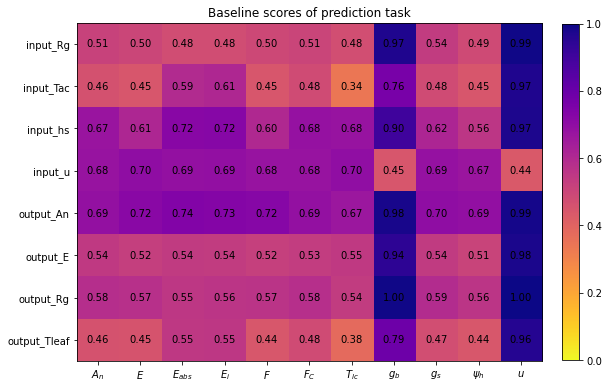

In [156]:
from collections import defaultdict

from util import VARIABLE_NAMES 

score_dict = defaultdict(lambda : {})
for target, var, model, base_score, tuned_score in baseline_scores:
  tuned_cv_mean, tuned_cv_std = tuned_score[1]
  score_dict[target][var] = tuned_cv_mean


baseline_nmse_matrix = np.empty((len(targets), len(variables)))
for row, (target, variable_dict) in enumerate(score_dict.items()):
  for col, (variable, score)  in enumerate(variable_dict.items()):
    baseline_nmse_matrix[row, col] = -score


fig, ax = plt.subplots(figsize=(9, 9))

img = ax.imshow(baseline_nmse_matrix, cmap='plasma_r', vmin=0, vmax=1)

# add value labels
for (col, row), value in np.ndenumerate(baseline_nmse_matrix):
  if not np.isnan(value):
    ax.text(row, col, f'{value:.2f}', ha='center', va='center')

ax.set_xticks(np.arange(len(variables)))    
ax.set_xticklabels([VARIABLE_NAMES[v] for v in variables])
ax.set_yticks(np.arange(len(targets)))    
ax.set_yticklabels(targets)

ax.set_title(f'Baseline scores of prediction task')
plt.colorbar(img, fraction=0.0335, pad=0.04)
plt.show()


## Predicting over moving window

Now we will train and evaluate a readout function over 30 day windows (30 runs at a time), with a step of 7 days each time.

In [157]:
"""To make things faster (and easier to visualize), let's select a
 subset of tasks and variables and a more limited search window."""

targets = ['input_Rg', 'output_An', 'output_E']
variables = ['Tlc', 'Flux', 'E', 'gs']

search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-2), np.log10(1e4), 25)
}]

In [158]:
"""Define the sliding window"""

WINDOW = 30
STEP = 3

N = len(runs)
slices = [(i, i + WINDOW) for i in range(0, N - WINDOW + STEP, STEP)]

In [159]:
"""Train and evaluate models over sliding window"""

model_targets = [(target, var) for target in targets for var in variables]
moving_scores = []

with tqdm(total=len(slices) * len(model_targets)) as pbar:
  for start, end in slices:
    window_scores = []
    for target, var in model_targets:
      result = evaluate_for_runs(readout, var, target, runs[start:end], N_CV_GROUPS, folds, search_grid, 
                                 state_size=STATE_SIZE, samples_per_run=SAMPLES_PER_RUN, 
                                 warmup_steps=WARMUP_STEPS, mask=DAYLIGHT_MASK)
      window_scores.append(result)
      pbar.update(1)
    moving_scores.append(window_scores)
  

100%|██████████| 228/228 [01:06<00:00,  3.43it/s]


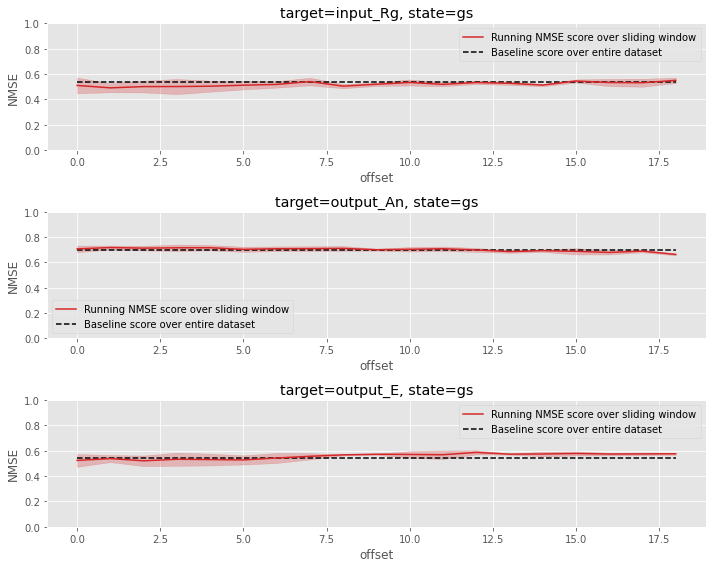

In [161]:
"""Plot evolution of NMSE for an example target and variable."""

variable = "gs"

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(3, 1, figsize=(10, 8))

  for row, target in enumerate(targets):
    # Gather data
    baseline_score = -score_dict[target][variable]
    scores = []  # insert tuples of (mean, std)
    for step_scores in moving_scores:
      for t, v, model, base_score, tuned_score in step_scores:
        if t == target and v == variable:
          scores.append(tuned_score[1])
          break
    means = -np.array([mean for (mean, std) in scores])
    p95 = np.array([std for (mean, std) in scores]) * 1.96 / np.sqrt(N_CV_GROUPS)

    # Plot data
    ax[row].set_ylim(0, 1)
    ax[row].plot(means, label="Running NMSE score over sliding window", color='tab:red')
    ax[row].fill_between(range(len(slices)), means - p95, means + p95, color='tab:red', alpha=0.25)
    ax[row].hlines(baseline_score, 0, len(slices) - 1, linestyle='dashed', label="Baseline score over entire dataset")
    ax[row].legend()
    ax[row].set_xlabel('offset')
    ax[row].set_ylabel('NMSE')
    ax[row].set_title(f'target={target}, state={variable}')

  plt.tight_layout()
  plt.show()